# Object Detection 

## Using Tensorflow Object Detection API 

If you want to train the model, make sure to follow the [installation instructions](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/installation.md) before you start.

If you want only to detect using the trained model, there is no need to install APIs.

### Imports

In [62]:
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image

# They requires 1.4, but it seems OK for 1.3.
#if tf.__version__ < '1.4.0':
#    raise ImportError('Please upgrade your tensorflow installation to v1.4.* or later!')

# This is needed to display the images.
%matplotlib inline

# This is needed since the notebook is stored in the object_detection folder.
sys.path.append("..")

## A. Detection

### 1. Load a (frozen) Tensorflow model into memory.

frozen_inference_graph.pb


In [63]:
# Path to frozen detection graph. This is the actual model that is used for the object detection.
#PATH_TO_CKPT = MODEL_NAME + '/frozen_inference_graph.pb'
PATH_TO_CKPT = 'models/fine_tuned_model' + '/frozen_inference_graph.pb'
# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = os.path.join('data', 'udacity_label_map.pbtxt') #'mscoco_label_map.pbtxt')

NUM_CLASSES = 4 #90

print(PATH_TO_CKPT)

detection_graph = tf.Graph()
with detection_graph.as_default():
    od_graph_def = tf.GraphDef()
    with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')

models/fine_tuned_model/frozen_inference_graph.pb


### 2. Loading label map
Label maps map indices to category names, so that when our convolution network predicts `5`, we know that this corresponds to `airplane`.  Here we use internal utility functions, but anything that returns a dictionary mapping integers to appropriate string labels would be fine

#### Object detection imports
Here are the imports from the object detection module.

In [64]:
from utils import label_map_util
from utils import visualization_utils as vis_util

In [65]:

label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)

#### Helper code

In [66]:
def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

In [67]:
# For the sake of simplicity we will use only 2 images:
# image1.jpg
# image2.jpg
# If you want to test the code with your images, just add path to the images to the TEST_IMAGE_PATHS.
PATH_TO_SIM_IMAGES_DIR = '/data/private/udacity_data/sim_training_data/sim_data_capture' # 'test_images'
PATH_TO_REAL_IMAGES_DIR = '/data/private/udacity_data/real_training_data'
PATH_TO_TEST_IMAGES_DIR = '/data/private/udacity_data/test_data'

TEST_IMAGE_PATHS = []
#TEST_IMAGE_PATHS = [ os.path.join(PATH_TO_TEST_IMAGES_DIR, 'image{}.jpg'.format(i)) for i in range(1, 3) ]
#TEST_IMAGE_PATHS = [ os.path.join(PATH_TO_SIM_TEST_IMAGES_DIR, 'left{}.jpg'.format(i)) for i in ['0020', '0051', '0478', '0031', '0557', '0588'] ] #0983

TEST_IMAGE_PATHS.extend(
    [ os.path.join(PATH_TO_TEST_IMAGES_DIR, 'frame{}.png'.format(i)) for i in ['000076', '000107', '000148'] ] #0983
)
#TEST_IMAGE_PATHS.extend([ os.path.join(PATH_TO_REAL_TEST_IMAGES_DIR, '{}.jpg'.format(i)) for i in ['green/left0577', 'green/left0381', 'red/left0144', 'yellow/left0082']])

# Size, in inches, of the output images.
IMAGE_SIZE = (14, 10)
print(TEST_IMAGE_PATHS)

['/data/private/udacity_data/test_data/frame000076.png', '/data/private/udacity_data/test_data/frame000107.png', '/data/private/udacity_data/test_data/frame000148.png']


### 3. Detect

('classes=', 4.0)
('scores=', 0.88559103)
('category_index=', {1: {'id': 1, 'name': u'None'}, 2: {'id': 2, 'name': u'Red'}, 3: {'id': 3, 'name': u'Yellow'}, 4: {'id': 4, 'name': u'Green'}})
('classes=', 3.0)
('scores=', 0.97402996)
('category_index=', {1: {'id': 1, 'name': u'None'}, 2: {'id': 2, 'name': u'Red'}, 3: {'id': 3, 'name': u'Yellow'}, 4: {'id': 4, 'name': u'Green'}})
('classes=', 2.0)
('scores=', 0.92765892)
('category_index=', {1: {'id': 1, 'name': u'None'}, 2: {'id': 2, 'name': u'Red'}, 3: {'id': 3, 'name': u'Yellow'}, 4: {'id': 4, 'name': u'Green'}})


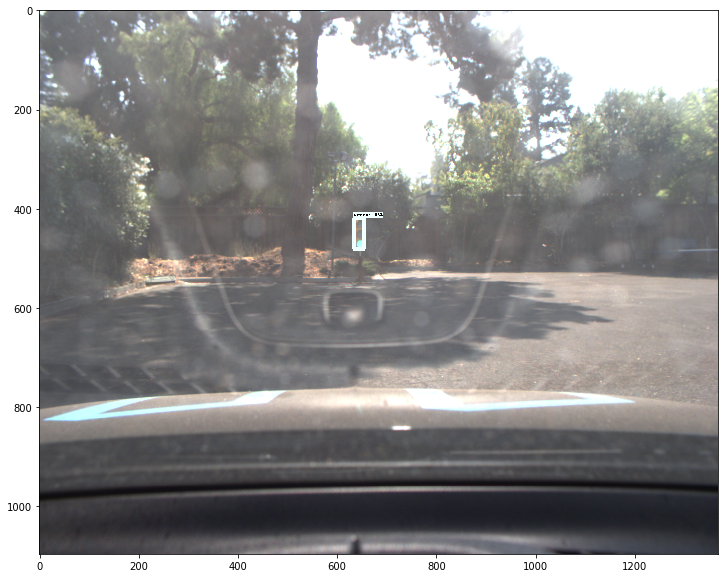

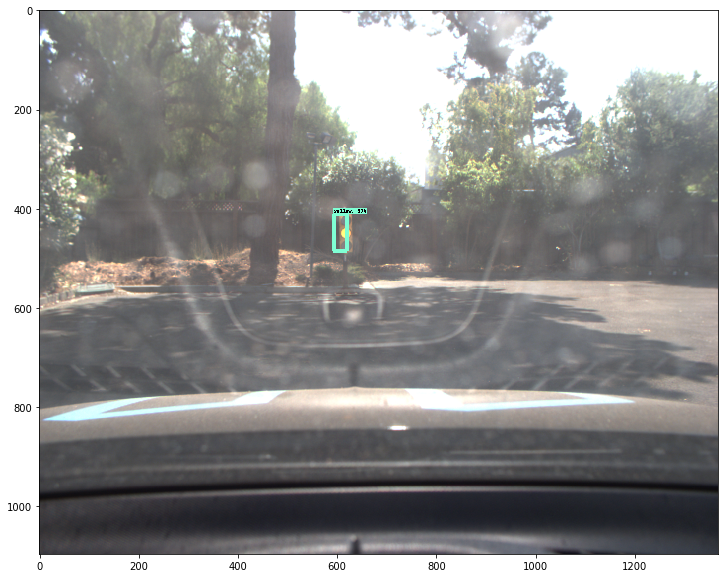

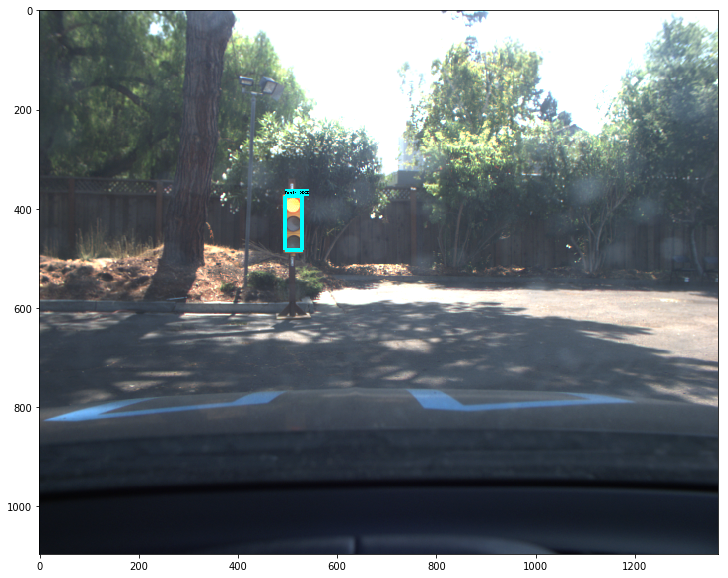

In [68]:

with detection_graph.as_default():
    with tf.Session(graph=detection_graph) as sess:
        # Definite input and output Tensors for detection_graph
        image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
        # Each box represents a part of the image where a particular object was detected.
        detection_boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
        # Each score represent how level of confidence for each of the objects.
        # Score is shown on the result image, together with the class label.
        detection_scores = detection_graph.get_tensor_by_name('detection_scores:0')
        detection_classes = detection_graph.get_tensor_by_name('detection_classes:0')
        num_detections = detection_graph.get_tensor_by_name('num_detections:0')

        for image_path in TEST_IMAGE_PATHS:
            image = Image.open(image_path)
            # the array based representation of the image will be used later in order to prepare the
            # result image with boxes and labels on it.
            image_np = load_image_into_numpy_array(image)
            # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
            image_np_expanded = np.expand_dims(image_np, axis=0)
            # Actual detection.
            (boxes, scores, classes, num) = sess.run(
              [detection_boxes, detection_scores, detection_classes, num_detections],
              feed_dict={image_tensor: image_np_expanded})
            # Visualization of the results of a detection.
            vis_util.visualize_boxes_and_labels_on_image_array(
              image_np,
              np.squeeze(boxes),
              np.squeeze(classes).astype(np.int32),
              np.squeeze(scores),
              category_index,
              use_normalized_coordinates=True,
              line_thickness=8)
            plt.figure(figsize=IMAGE_SIZE)
            plt.imshow(image_np)
            print('classes=', np.squeeze(classes)[0])
            print('scores=', np.squeeze(scores)[0])
            print('category_index=', category_index)
        

## B. [training](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/running_locally.md): Transfer Learning



### 1. Download pretrained Exported Model

Any model exported using the `export_inference_graph.py` tool can be loaded here simply by changing `PATH_TO_CKPT` to point to a new .pb file.  

I used an "SSD with Mobilenet" model here. See the [detection model zoo](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/detection_model_zoo.md) for a list of other models that can be run out-of-the-box with varying speeds and accuracies.

In [4]:
# What model to download.
MODEL_NAME = 'ssd_mobilenet_v1_coco_2017_11_17'
MODEL_FILE = MODEL_NAME + '.tar.gz'
DOWNLOAD_BASE = 'http://download.tensorflow.org/models/object_detection/'



In [20]:
#opener = urllib.request.URLopener()
#opener.retrieve(DOWNLOAD_BASE + MODEL_FILE, MODEL_FILE)
print(os.getcwd())
tar_file = tarfile.open(MODEL_FILE)
for file in tar_file.getmembers():
  file_name = os.path.basename(file.name)
  if 'frozen_inference_graph.pb' in file_name:
    tar_file.extract(file, os.getcwd())

/home/jude.o/models/research/object_detection


### 2. Preparing Your Own Training Dataset
which should be converted to **TFRecord**

[Preparing Inputs](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/using_your_own_dataset.md)

In [33]:
from object_detection.utils import dataset_util
import yaml

def label_to_int(label):
    label_map = {'None': 1, 'Red': 2, 'Yellow': 3, 'Green': 4}
    return label_map[label]

def create_tf_example(datapath, example, w, h):
    
    height = h # Image height
    width = w # Image width
    filename = example['filename'] # Filename of the image. Empty if image is not from file
    image_path = os.path.join(datapath, filename)
    with tf.gfile.GFile(image_path, 'rb') as fid:
        encoded_image_data = fid.read() # Encoded image bytes
    
    print('image_path=', image_path)
    print('encoded_image_data len=', len(encoded_image_data))
    image_format = b'jpeg' # b'jpeg' or b'png'

    xmins = [] # List of normalized left x coordinates in bounding box (1 per box)
    xmaxs = [] # List of normalized right x coordinates in bounding box
             # (1 per box)
    ymins = [] # List of normalized top y coordinates in bounding box (1 per box)
    ymaxs = [] # List of normalized bottom y coordinates in bounding box
             # (1 per box)
    classes_text = [] # List of string class name of bounding box (1 per box)
    classes = [] # List of integer class id of bounding box (1 per box)


    for annot in example['annotations']:
        xmin = annot['xmin']/width
        xmins.append(xmin)
        xmax = (annot['xmin']+annot['x_width'])/width
        xmaxs.append(xmax)
        ymin = annot['ymin']/height
        ymins.append(ymin)
        ymax = (annot['ymin']+annot['y_height'])/height
        ymaxs.append(ymax)
        
        classes_text.append(annot['class'])
        classes.append(label_to_int(annot['class']))
    
    if classes == []:
        return None
        classes_text.append('None')
        classes.append(0)
    
    print('classes=', classes, 'ids=', classes_text, 'xmaxs=', xmaxs)
        
    tf_example = tf.train.Example(features=tf.train.Features(feature={
      'image/height': dataset_util.int64_feature(height),
      'image/width': dataset_util.int64_feature(width),
      'image/filename': dataset_util.bytes_feature(filename),
      'image/source_id': dataset_util.bytes_feature(filename),
      'image/encoded': dataset_util.bytes_feature(encoded_image_data),
      'image/format': dataset_util.bytes_feature(image_format),
      'image/object/bbox/xmin': dataset_util.float_list_feature(xmins),
      'image/object/bbox/xmax': dataset_util.float_list_feature(xmaxs),
      'image/object/bbox/ymin': dataset_util.float_list_feature(ymins),
      'image/object/bbox/ymax': dataset_util.float_list_feature(ymaxs),
      'image/object/class/text': dataset_util.bytes_list_feature(classes_text),
      'image/object/class/label': dataset_util.int64_list_feature(classes),
    }))
    return tf_example


def dataset_to_TFrecord(datapath, yamlfile, w, h):
    
    #flags = tf.app.flags
    #flags.DEFINE_string('output_path', '/home/jude.o/models/research/object_detection/data/udacity_train.record', 'Path to output TFRecord')


    yaml_path = os.path.join(datapath, yamlfile)
    stream = open(yaml_path, "r")
    examples = yaml.load(stream)
    for i, example in enumerate(examples):
        print('count=', i)

        tf_example = create_tf_example(datapath, example, w, h)
        if tf_example:
            writer.write(tf_example.SerializeToString())



output_path = '/home/jude.o/models/research/object_detection/data/udacity_train.record'
writer = tf.python_io.TFRecordWriter(output_path) #flags.FLAGS.output_path)

dataset_to_TFrecord('/data/private/udacity_data/sim_training_data', 'sim_data_annotations.yaml', 800, 600)
dataset_to_TFrecord('/data/private/udacity_data/real_training_data', 'real_data_annotations.yaml', 1368, 1096)

writer.close()



('count=', 0)
('image_path=', '/data/private/udacity_data/sim_training_data/sim_data_capture/left0003.jpg')
('encoded_image_data len=', 74566)
('classes=', [4, 4, 4], 'ids=', ['Green', 'Green', 'Green'], 'xmaxs=', [0.22893617021276594, 0.5321985815602837, 0.846241134751773])
('count=', 1)
('image_path=', '/data/private/udacity_data/sim_training_data/sim_data_capture/left0011.jpg')
('encoded_image_data len=', 75008)
('classes=', [3, 3, 3], 'ids=', ['Yellow', 'Yellow', 'Yellow'], 'xmaxs=', [0.2228, 0.5307999999999999, 0.8423999999999999])
('count=', 2)
('image_path=', '/data/private/udacity_data/sim_training_data/sim_data_capture/left0012.jpg')
('encoded_image_data len=', 74967)
('classes=', [3, 3, 3], 'ids=', ['Yellow', 'Yellow', 'Yellow'], 'xmaxs=', [0.2232, 0.5364, 0.8472])
('count=', 3)
('image_path=', '/data/private/udacity_data/sim_training_data/sim_data_capture/left0013.jpg')
('encoded_image_data len=', 74629)
('classes=', [3, 3, 3], 'ids=', ['Yellow', 'Yellow', 'Yellow'], 'xmaxs=

('encoded_image_data len=', 51974)
('classes=', [2, 2], 'ids=', ['Red', 'Red'], 'xmaxs=', [0.1431060994947078, 0.20426663617358123])
('count=', 93)
('image_path=', '/data/private/udacity_data/sim_training_data/sim_data_capture/left0457.jpg')
('encoded_image_data len=', 45284)
('classes=', [2, 2], 'ids=', ['Red', 'Red'], 'xmaxs=', [0.3559734361387556, 0.4159394310856198])
('count=', 94)
('image_path=', '/data/private/udacity_data/sim_training_data/sim_data_capture/left0458.jpg')
('encoded_image_data len=', 41001)
('classes=', [2, 2, 2], 'ids=', ['Red', 'Red', 'Red'], 'xmaxs=', [0.39348204652384594, 0.45344804147071016, 0.5155642115351909])
('count=', 95)
('image_path=', '/data/private/udacity_data/sim_training_data/sim_data_capture/left0459.jpg')
('encoded_image_data len=', 41001)
('classes=', [2, 2, 2], 'ids=', ['Red', 'Red', 'Red'], 'xmaxs=', [0.3956322216414626, 0.455359308241925, 0.5160420282279947])
('count=', 96)
('image_path=', '/data/private/udacity_data/sim_training_data/sim_da

('image_path=', '/data/private/udacity_data/sim_training_data/sim_data_capture/left0492.jpg')
('encoded_image_data len=', 46365)
('classes=', [2, 2, 2], 'ids=', ['Red', 'Red', 'Red'], 'xmaxs=', [0.2764169567869397, 0.36791885345884806, 0.45512039989552305])
('count=', 129)
('image_path=', '/data/private/udacity_data/sim_training_data/sim_data_capture/left0493.jpg')
('encoded_image_data len=', 46476)
('classes=', [2, 2, 2], 'ids=', ['Red', 'Red', 'Red'], 'xmaxs=', [0.2742667816693231, 0.36337959487721294, 0.4541647665099157])
('count=', 130)
('image_path=', '/data/private/udacity_data/sim_training_data/sim_data_capture/left0494.jpg')
('encoded_image_data len=', 46233)
('classes=', [2, 2, 2], 'ids=', ['Red', 'Red', 'Red'], 'xmaxs=', [0.27020533978049166, 0.36337959487721294, 0.455359308241925])
('count=', 131)
('image_path=', '/data/private/udacity_data/sim_training_data/sim_data_capture/left0495.jpg')
('encoded_image_data len=', 46258)
('classes=', [2, 2, 2], 'ids=', ['Red', 'Red', 'Red

('encoded_image_data len=', 43618)
('classes=', [2, 2, 2], 'ids=', ['Red', 'Red', 'Red'], 'xmaxs=', [0.41283362258239575, 0.5590455305803276, 0.6992847299182132])
('count=', 163)
('image_path=', '/data/private/udacity_data/sim_training_data/sim_data_capture/left0527.jpg')
('encoded_image_data len=', 43585)
('classes=', [2, 2, 2], 'ids=', ['Red', 'Red', 'Red'], 'xmaxs=', [0.4257346732880956, 0.5736189397108403, 0.71696394755195])
('count=', 164)
('image_path=', '/data/private/udacity_data/sim_training_data/sim_data_capture/left0528.jpg')
('encoded_image_data len=', 44496)
('classes=', [2, 2, 2], 'ids=', ['Red', 'Red', 'Red'], 'xmaxs=', [0.4436527992682343, 0.5967930493118199, 0.7379878820353127])
('count=', 165)
('image_path=', '/data/private/udacity_data/sim_training_data/sim_data_capture/left0529.jpg')
('encoded_image_data len=', 44649)
('classes=', [2, 2, 2], 'ids=', ['Red', 'Red', 'Red'], 'xmaxs=', [0.4524924080851027, 0.6061104748214919, 0.7582950914794699])
('count=', 166)
('image

('encoded_image_data len=', 47086)
('classes=', [4, 4, 4], 'ids=', ['Green', 'Green', 'Green'], 'xmaxs=', [0.2021164610559646, 0.4696938090260359, 0.7320151733752666])
('count=', 196)
('image_path=', '/data/private/udacity_data/sim_training_data/sim_data_capture/left0560.jpg')
('encoded_image_data len=', 47074)
('classes=', [4, 4, 4], 'ids=', ['Green', 'Green', 'Green'], 'xmaxs=', [0.19232121885348877, 0.47423306760767103, 0.7377489736889109])
('count=', 197)
('image_path=', '/data/private/udacity_data/sim_training_data/sim_data_capture/left0561.jpg')
('encoded_image_data len=', 46076)
('classes=', [4, 4, 4], 'ids=', ['Green', 'Green', 'Green'], 'xmaxs=', [0.19136558546788138, 0.4763832427252877, 0.7461107658129756])
('count=', 198)
('image_path=', '/data/private/udacity_data/sim_training_data/sim_data_capture/left0562.jpg')
('encoded_image_data len=', 46551)
('classes=', [4, 4, 4], 'ids=', ['Green', 'Green', 'Green'], 'xmaxs=', [0.18634851019344253, 0.47471088430047476, 0.748260940930

('encoded_image_data len=', 51266)
('classes=', [2, 2, 2], 'ids=', ['Red', 'Red', 'Red'], 'xmaxs=', [0.14070921985815607, 0.4740425531914895, 0.7900709219858159])
('count=', 230)
('image_path=', '/data/private/udacity_data/sim_training_data/sim_data_capture/left0594.jpg')
('encoded_image_data len=', 51131)
('classes=', [2, 2, 2], 'ids=', ['Red', 'Red', 'Red'], 'xmaxs=', [0.1412765957446809, 0.4669503546099293, 0.7914893617021279])
('count=', 231)
('image_path=', '/data/private/udacity_data/sim_training_data/sim_data_capture/left0595.jpg')
('encoded_image_data len=', 51274)
('classes=', [2, 2, 2], 'ids=', ['Red', 'Red', 'Red'], 'xmaxs=', [0.13702127659574473, 0.4740425531914895, 0.7954609929078016])
('count=', 232)
('image_path=', '/data/private/udacity_data/sim_training_data/sim_data_capture/left0596.jpg')
('encoded_image_data len=', 51274)
('classes=', [2, 2, 2], 'ids=', ['Red', 'Red', 'Red'], 'xmaxs=', [0.13900709219858162, 0.47375886524822713, 0.795744680851064])
('count=', 233)
('i

('encoded_image_data len=', 50199)
('classes=', [2, 2, 2], 'ids=', ['Red', 'Red', 'Red'], 'xmaxs=', [0.3170195149772061, 0.4137689233427778, 0.509501700447065])
('count=', 270)
('image_path=', '/data/private/udacity_data/sim_training_data/sim_data_capture/left0983.jpg')
('encoded_image_data len=', 52433)
('classes=', [2, 2, 2], 'ids=', ['Red', 'Red', 'Red'], 'xmaxs=', [0.2829623677241765, 0.40580531179604945, 0.5232262224744053])
('count=', 271)
('image_path=', '/data/private/udacity_data/sim_training_data/sim_data_capture/left0984.jpg')
('encoded_image_data len=', 52855)
('classes=', [2, 2, 2], 'ids=', ['Red', 'Red', 'Red'], 'xmaxs=', [0.27449044054680594, 0.404788680534765, 0.5291565714985648])
('count=', 272)
('image_path=', '/data/private/udacity_data/sim_training_data/sim_data_capture/left0987.jpg')
('encoded_image_data len=', 53610)
('classes=', [2, 2, 2], 'ids=', ['Red', 'Red', 'Red'], 'xmaxs=', [0.2594104101710863, 0.401908225294459, 0.5355952361533663])
('count=', 273)
('image

('image_path=', '/data/private/udacity_data/real_training_data/red/left0180.jpg')
('encoded_image_data len=', 372883)
('classes=', [2], 'ids=', ['Red'], 'xmaxs=', [0.15923444777007523])
('count=', 39)
('image_path=', '/data/private/udacity_data/real_training_data/red/left0186.jpg')
('encoded_image_data len=', 378729)
('classes=', [2], 'ids=', ['Red'], 'xmaxs=', [0.07568227048050528])
('count=', 40)
('image_path=', '/data/private/udacity_data/real_training_data/red/left0260.jpg')
('encoded_image_data len=', 375654)
('classes=', [2], 'ids=', ['Red'], 'xmaxs=', [0.11358898827750014])
('count=', 41)
('image_path=', '/data/private/udacity_data/real_training_data/red/left0451.jpg')
('encoded_image_data len=', 323353)
('classes=', [2], 'ids=', ['Red'], 'xmaxs=', [0.4878882679253463])
('count=', 42)
('image_path=', '/data/private/udacity_data/real_training_data/red/left0452.jpg')
('encoded_image_data len=', 322809)
('classes=', [2], 'ids=', ['Red'], 'xmaxs=', [0.4871864050674888])
('count=', 4

('image_path=', '/data/private/udacity_data/real_training_data/yellow/left0435.jpg')
('encoded_image_data len=', 322160)
('classes=', [3], 'ids=', ['Yellow'], 'xmaxs=', [0.48772394736842156])
('count=', 80)
('image_path=', '/data/private/udacity_data/real_training_data/yellow/left0436.jpg')
('encoded_image_data len=', 322254)
('classes=', [3], 'ids=', ['Yellow'], 'xmaxs=', [0.4880146052631584])
('count=', 81)
('image_path=', '/data/private/udacity_data/real_training_data/yellow/left0444.jpg')
('encoded_image_data len=', 322683)
('classes=', [3], 'ids=', ['Yellow'], 'xmaxs=', [0.48786927631578997])
('count=', 82)
('image_path=', '/data/private/udacity_data/real_training_data/yellow/left0445.jpg')
('encoded_image_data len=', 322982)
('classes=', [3], 'ids=', ['Yellow'], 'xmaxs=', [0.4872879605263163])
('count=', 83)
('image_path=', '/data/private/udacity_data/real_training_data/yellow/left0700.jpg')
('encoded_image_data len=', 360083)
('classes=', [3], 'ids=', ['Yellow'], 'xmaxs=', [0.23

('encoded_image_data len=', 322845)
('classes=', [4], 'ids=', ['Green'], 'xmaxs=', [0.4867643515356291])
('count=', 127)
('image_path=', '/data/private/udacity_data/real_training_data/green/left0016.jpg')
('encoded_image_data len=', 322871)
('classes=', [4], 'ids=', ['Green'], 'xmaxs=', [0.4867643515356291])
('count=', 128)
('image_path=', '/data/private/udacity_data/real_training_data/green/left0017.jpg')
('encoded_image_data len=', 322939)
('classes=', [4], 'ids=', ['Green'], 'xmaxs=', [0.4866324013183519])
('count=', 129)
('image_path=', '/data/private/udacity_data/real_training_data/green/left0018.jpg')
('encoded_image_data len=', 323087)
('classes=', [4], 'ids=', ['Green'], 'xmaxs=', [0.48722617729609935])
('count=', 130)
('image_path=', '/data/private/udacity_data/real_training_data/green/left0019.jpg')
('encoded_image_data len=', 323505)
('classes=', [4], 'ids=', ['Green'], 'xmaxs=', [0.48709422707882216])
('count=', 131)
('image_path=', '/data/private/udacity_data/real_training



### 3. [Configuring the Object Detection Training Pipeline](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/configuring_jobs.md)

* The **model** configuration. 
    This defines what type of model will be trained (ie. meta-architecture, feature extractor).
* The **train_config**, 
    which decides what parameters should be used to train model parameters (ie. SGD parameters, input preprocessing and feature extractor initialization values).
* The **eval_config**, 
    which determines what set of metrics will be reported for evaluation (currently we only support the PASCAL VOC metrics).
* The **train_input_config**, 
    which defines what dataset the model should be trained on.
* The **eval_input_config**, 
    which defines what dataset the model will be evaluated on. Typically this should be different than the training input dataset.
    
* [config](https://github.com/tensorflow/models/blob/master/research/object_detection/samples/configs/ssd_mobilenet_v1_coco.config)



#### Recommended Directory Structure for Training and Evaluation
```
+data
  -label_map file
  -train TFRecord file
  -eval TFRecord file
+models
  + model
    -pipeline config file
    +train
    +eval
```

### 4. Running the Training Job
[train.py](https://github.com/tensorflow/models/blob/master/research/object_detection/train.py)
-> [trainer.py](https://github.com/tensorflow/models/blob/master/research/object_detection/trainer.py)
```
# From the tensorflow/models/research/object_detection directory
python train.py \
    --logtostderr \
    --train_dir models/train \
    --pipeline_config_path models/model/ssd_mobilenet_v1_full.config


# or if you have seperate configs
python train.py \
    --logtostderr \
    --train_dir=${PATH_TO_TRAIN_DIR} \
    --model_config_path=model_config.pbtxt \
    --train_config_path=train_config.pbtxt \
    --input_config_path=train_input_config.pbtxt
```

### 5. Running the Evaluation Job
[eval.py](https://github.com/tensorflow/models/blob/master/research/object_detection/eval.py)
-> [evaluator.py](https://github.com/tensorflow/models/blob/master/research/object_detection/evaluator.py)
```
# From the tensorflow/models/research/obejct_detection directory
python eval.py \
    --logtostderr \
    --pipeline_config_path=${PATH_TO_YOUR_PIPELINE_CONFIG} \
    --checkpoint_dir=${PATH_TO_TRAIN_DIR} \
    --eval_dir=${PATH_TO_EVAL_DIR}
```

#### Running Tensorboard
```
tensorboard --logdir=${PATH_TO_MODEL_DIRECTORY}
```

### 6. [Exporting a trained model for inference](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/exporting_models.md)

After your model has been trained, you should export it to a Tensorflow graph proto. A checkpoint will typically consist of three files:

* model.ckpt-\${CHECKPOINT_NUMBER}.data-00000-of-00001,
* model.ckpt-\${CHECKPOINT_NUMBER}.index
* model.ckpt-\${CHECKPOINT_NUMBER}.meta

After you've identified a candidate checkpoint to export, 
run the following command.
```
# from tensorflow/models/research/object_detection directory:
python export_inference_graph.py \
    --input_type image_tensor \
    --pipeline_config_path models/model/ssd_mobilenet_v1_udacity.config \
    --trained_checkpoint_prefix models/train/model.ckpt-20000 \
    --output_directory models/fine_tuned_model
```
Afterwards, you should see a graph named **frozen_inference_graph.pb**.